In [1]:
import numpy as np
from sksurv.metrics import concordance_index_censored

from api.coxkan import *
from api.auton import datasets, preprocessing

In [2]:
from api.survset.data import SurvLoader

loader = SurvLoader()
# List of available datasets and meta-info
loader.df_ds.head()

,ds,is_td,n,n_fac,n_ohe,n_num
0,hdfail,False,52422,5,87,1
1,stagec,False,146,4,15,3
2,veteran,False,137,3,5,3
3,vdv,False,78,0,0,4705
4,AML_Bull,False,116,0,0,6283


In [3]:
# Load dataset and its reference
df, ref = loader.load_dataset(ds_name='GBSG2').values()
# support2, 
df

,pid,event,time,num_age,num_tsize,num_pnodes,num_progrec,num_estrec,fac_horTh,fac_menostat,fac_tgrade
0,0,1,1814,70,21,3,48,66,no,Post,II
1,1,1,2018,56,12,7,61,77,yes,Post,II
2,2,1,712,58,35,9,52,271,yes,Post,II
3,3,1,1807,59,17,4,60,29,yes,Post,II
4,4,1,772,73,35,1,26,65,no,Post,II
...,...,...,...,...,...,...,...,...,...,...,...
681,681,0,721,49,30,3,1,84,no,Pre,III
682,682,0,186,53,25,17,0,0,yes,Post,III
683,683,1,769,51,25,5,43,0,no,Pre,III
684,684,1,727,52,23,3,15,34,no,Post,II


In [4]:
cat_feats, num_feats = [], []
for i in df.columns:
    if i.split('_')[0] == 'num':
        num_feats.append(i)
    if i.split('_')[0] == 'fac':
        cat_feats.append(i)

In [5]:
features = preprocessing.Preprocessor().fit_transform(
    df[num_feats + cat_feats], cat_feats=cat_feats, num_feats=num_feats)
features

,num_age,num_tsize,num_pnodes,num_progrec,num_estrec,fac_horTh_yes,fac_menostat_Pre,fac_tgrade_II,fac_tgrade_III
0,1.675756,-0.583058,-0.367396,-0.306630,-0.197762,0,0,1,0
1,0.291448,-1.213055,0.363666,-0.242332,-0.125854,1,0,1,0
2,0.489207,0.396937,0.729197,-0.286846,1.142349,1,0,1,0
3,0.588086,-0.863056,-0.184630,-0.247278,-0.439636,1,0,1,0
4,1.972393,0.396937,-0.732927,-0.415441,-0.204300,0,0,1,0
...,...,...,...,...,...,...,...,...,...
681,-0.400705,0.046939,-0.367396,-0.539091,-0.080094,0,1,0,1
682,-0.005189,-0.303060,2.191322,-0.544037,-0.629213,1,0,0,1
683,-0.202947,-0.303060,-0.001865,-0.331360,-0.629213,0,1,0,1
684,-0.104068,-0.443059,-0.367396,-0.469847,-0.406951,0,0,1,0


In [6]:
x, t, e = features.values, df.time.values, df.event.values
# x = x[:,:10]
x

array([[ 1.67575586, -0.58305801, -0.36739603, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.29144834, -1.21305453,  0.36366612, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.48920655,  0.39693659,  0.7291972 , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.20294721, -0.30305955, -0.00186495, ...,  1.        ,
         0.        ,  1.        ],
       [-0.1040681 , -0.44305878, -0.36739603, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.19256923, -0.44305878,  0.7291972 , ...,  0.        ,
         1.        ,  0.        ]])

In [7]:
# horizons = [0.25, 0.5, 0.75]
# times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()
# times

In [8]:
n = len(x)

tr_size = int(n * 0.70)
vl_size = int(n * 0.10)
te_size = int(n * 0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

### Get started with KANs

Initialize KAN

In [9]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = CoxKAN(width=[x_train.shape[1], 1], grid=5, k=3, seed=0)
# model = KAN(width=[2,1,1], grid=5, k=3, seed=0)
optimizer = 'LBFGS'

Create dataset

In [10]:
device='cpu'
dataset = {
    'train_input': torch.from_numpy(x_train).to(device), 
    'val_input': torch.from_numpy(x_val).to(device),
    'test_input': torch.from_numpy(x_test).to(device),
    'train_time': torch.from_numpy(t_train).to(device), 
    'val_time': torch.from_numpy(t_val).to(device),
    'test_time': torch.from_numpy(t_test).to(device),
    'train_event': torch.from_numpy(e_train).to(device),
    'val_event': torch.from_numpy(e_val).to(device),
    'test_event': torch.from_numpy(e_test).to(device)}

Plot KAN at initialization

In [11]:
print(dataset['train_input'].shape)
print(dataset['val_input'].shape)
print(dataset['test_input'].shape)

torch.Size([480, 9])
torch.Size([68, 9])
torch.Size([137, 9])


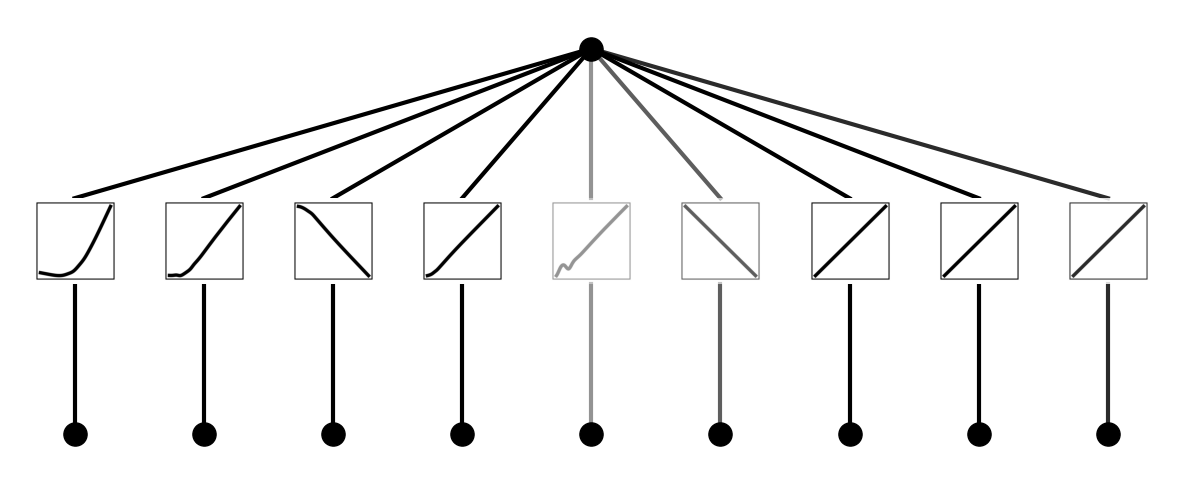

In [12]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot(beta=100, scale=1.5)

Train KAN with sparsity regularization

In [13]:
# train the model
model.train()
lr = 0.01
model.fit(dataset, opt=optimizer, steps=20, lr=lr, lamb=0.01, lamb_entropy=10., batch=-1)

train loss: 3.42e+01 | validation loss: 1.09e+01 | reg: 2.89e+01 : 100%|█| 20/20 [00:03<00:00,  5.71


{'train_loss': [array(34.99639433),
  array(34.47566806),
  array(34.25273732),
  array(34.2232052),
  array(34.21365872),
  array(34.20141577),
  array(34.20183962),
  array(34.20047596),
  array(34.20046398),
  array(34.18983155),
  array(34.18944788),
  array(34.18816973),
  array(34.18754971),
  array(34.18509078),
  array(34.18445443),
  array(34.18450228),
  array(34.18249747),
  array(34.18238201),
  array(34.1820927),
  array(34.18389071)],
 'val_loss': [array(10.89046237),
  array(10.74871953),
  array(10.82181992),
  array(10.83473874),
  array(10.83896054),
  array(10.86073498),
  array(10.86068048),
  array(10.86133808),
  array(10.86249265),
  array(10.90419124),
  array(10.91466039),
  array(10.91202646),
  array(10.911587),
  array(10.91225168),
  array(10.9129144),
  array(10.91766272),
  array(10.91363186),
  array(10.9136048),
  array(10.9136044),
  array(10.91360327)],
 'reg': [array(24.6711703),
  array(25.59633253),
  array(25.96371286),
  array(26.03626196),
  arr

Plot trained KAN

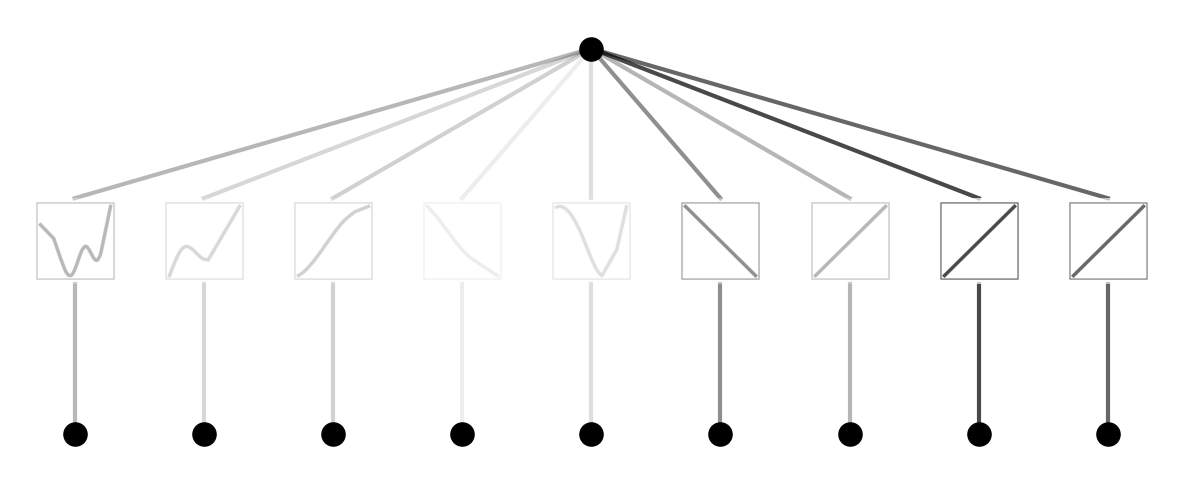

In [14]:
model.plot(scale=1.5)

In [15]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([ 1.59453479,  1.58666093, -2.09965495, -0.97433972, -0.78692896,
        0.82218194,  1.40909377,  0.46591481,  0.64528473, -0.68355058,
       -0.54428325, -0.6146537 ,  1.47634656,  0.44427296, -0.54802938,
        0.22406977, -0.71345199,  1.28099726, -0.37849619,  0.24510642,
       -0.0850456 ,  0.53502973, -0.55466439, -0.53069195,  0.62179658,
        0.72940668, -0.65820255,  1.11002766,  1.17334503,  0.30093271,
       -0.42435212,  0.98520272,  1.17828467, -1.58090988, -1.70137509,
       -0.81667897, -0.54515968, -0.34806299, -0.93843746,  0.56484163,
        1.01662888,  2.27631987, -1.34635201,  0.19938037,  0.06938458,
       -0.54367153,  0.06238192, -0.08331391, -0.25111596, -3.39479442,
        1.89899741,  0.77148066, -0.5913118 , -0.25514505, -0.47630539,
       -0.80006331,  0.09071453,  0.29611832,  0.55522303, -0.0932441 ,
        1.85341683,  0.0767518 , -0.16050471, -0.09571396,  0.45622036,
        0.04218146, -0.5047482 , -0.74738149,  0.32167574, -0.27

In [16]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten()
)[0]

0.6706901075833115

Prune KAN and replot (keep the original shape)

In [17]:
# model.prune()
# model.plot(mask=True, scale=1.5)

Prune KAN and replot (get a smaller shape)

In [18]:
# model = model.prune()
# model(dataset['train_input'])
# model.plot(scale=1.5)

Continue training and replot

In [19]:
# model.fit(dataset, opt=optimizer, lr=lr, steps=50)

In [20]:
# model.plot(scale=1.5)

In [21]:
# concordance_index_censored(
#     dataset['test_event'] != 0, 
#     dataset['test_time'], 
#     model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

Automatically or manually set activation functions to be symbolic

In [22]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin')
    model.fix_symbolic(0,1,0,'x^2')
    model.fix_symbolic(1,0,0,'exp')
elif mode == "auto":
    # automatic mode
    # lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.402348287665364
fixing (0,1,0) with x^3, r2=0.8183992182182701
fixing (0,2,0) with tanh, r2=0.9986272073242909
fixing (0,3,0) with tanh, r2=0.9973472612818406
fixing (0,4,0) with x^2, r2=0.8673150878033685
fixing (0,5,0) with exp, r2=1.0000000000000013
fixing (0,6,0) with exp, r2=1.0000000000000013
fixing (0,7,0) with exp, r2=1.0000000000000016
fixing (0,8,0) with exp, r2=1.0000000000000016


Continue training to almost machine precision

In [23]:
model.fit(dataset, opt=optimizer, lr=lr, steps=20, batch=-1)

train loss: 3.45e+01 | validation loss: 1.09e+01 | reg: 6.55e+00 : 100%|█| 20/20 [00:01<00:00, 18.44


{'train_loss': [array(34.51761045),
  array(34.51771031),
  array(34.51708782),
  array(34.51678385),
  array(34.51728995),
  array(34.51695794),
  array(34.51667375),
  array(34.51819261),
  array(34.51706195),
  array(34.51794833),
  array(34.51401408),
  array(34.513293),
  array(34.51393207),
  array(34.51396816),
  array(34.51436607),
  array(34.51406353),
  array(34.5138832),
  array(34.51494595),
  array(34.51353497),
  array(34.5144464)],
 'val_loss': [array(10.90262847),
  array(10.90198232),
  array(10.90262847),
  array(10.90262847),
  array(10.90188264),
  array(10.90252897),
  array(10.90252897),
  array(10.90252897),
  array(10.90252897),
  array(10.90244246),
  array(10.89483785),
  array(10.89549762),
  array(10.89540242),
  array(10.89522401),
  array(10.89522401),
  array(10.89515205),
  array(10.89424816),
  array(10.8947697),
  array(10.89401671),
  array(10.89459268)],
 'reg': [array(6.52962889),
  array(6.52962869),
  array(6.5296312),
  array(6.52963007),
  array

Obtain the symbolic formula

In [39]:
model.symbolic_formula(floating_digit=3)[0][0]

0.252386523817366*(-x_1 - 0.468302304622898)**2 - 0.698720753192902
-0.0423893072009152*(1 - 0.837906042174574*x_2)**3 + 0.252386523817366*(-x_1 - 0.468302304622898)**2 - 0.202008038759232
-0.0423893072009152*(1 - 0.837906042174574*x_2)**3 + 0.252386523817366*(-x_1 - 0.468302304622898)**2 + 0.804638147354126*tanh(0.9932000041008*x_3 - 0.310639709234238) - 0.353797987103462
-0.0423893072009152*(1 - 0.837906042174574*x_2)**3 + 0.252386523817366*(-x_1 - 0.468302304622898)**2 + 0.804638147354126*tanh(0.9932000041008*x_3 - 0.310639709234238) - 3.36654758453369*tanh(0.16399984061718*x_4 + 1.45557556257748e-16) - 0.550434172153473
-0.0423893072009152*(1 - 0.837906042174574*x_2)**3 + 0.20295965211874*(1 - 0.676301332183967*x_5)**2 + 0.252386523817366*(-x_1 - 0.468302304622898)**2 + 0.804638147354126*tanh(0.9932000041008*x_3 - 0.310639709234238) - 3.36654758453369*tanh(0.16399984061718*x_4 + 1.45557556257748e-16) - 0.536674797534943
-0.0423893072009152*(1 - 0.837906042174574*x_2)**3 + 0.2029596

-0.042*(1 - 0.838*x_2)**3 + 0.203*(1 - 0.676*x_5)**2 + 0.252*(-x_1 - 0.468)**2 + 0.001*exp(6.65*x_8) - 3.367*tanh(0.164*x_4) + 0.805*tanh(0.993*x_3 - 0.311) - 0.762

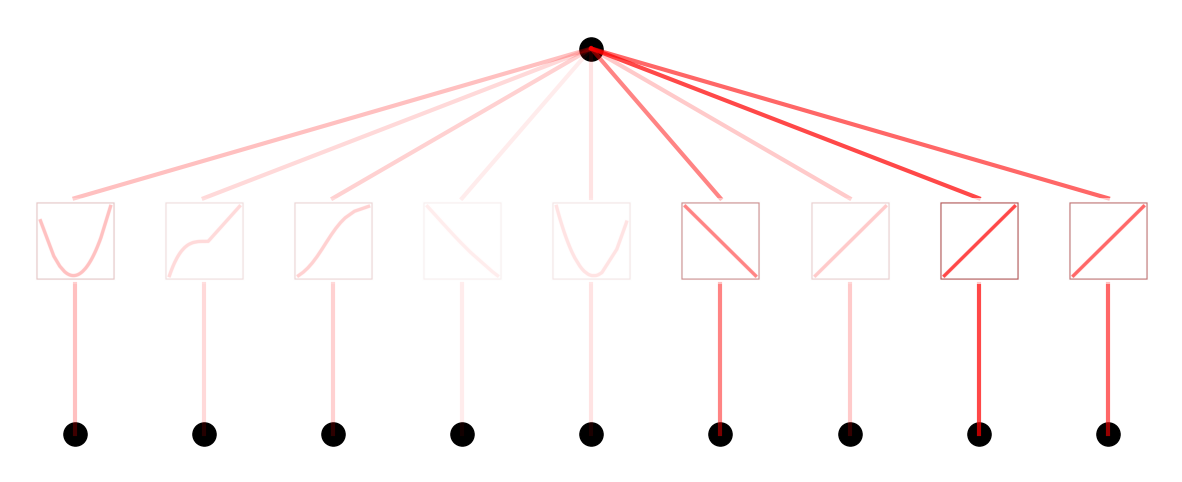

In [25]:
model.plot(scale=1.5)

In [26]:
model(dataset['test_input']).detach().cpu().numpy().flatten()

array([ 1.01970964,  1.14314984, -1.41647196, -1.62817614, -1.16321412,
        1.23056922,  1.46415211,  0.25919207,  0.37357708, -0.66064928,
       -0.25241448, -0.17302015,  1.17190448,  0.68710175, -0.66390593,
        0.69563451, -0.36168199,  1.38380678,  0.49332178,  0.31804991,
       -0.21582901,  0.13862002, -0.35639388, -0.30170892,  0.35122452,
        0.43205459, -0.89683569,  0.25355619,  0.6702689 ,  0.43672095,
       -0.14657225,  0.77748888,  1.4776987 , -1.08872118, -1.27514614,
       -1.11792123, -0.1821828 , -0.5398686 , -0.71945209,  0.42897399,
        1.43097835,  1.75307045, -1.12105773,  0.25733942,  0.36235095,
       -0.39020812, -0.12517612, -0.14583504, -0.60553247, -3.46657207,
        1.53473401,  1.19614445, -0.31804069, -0.3664338 , -0.0998642 ,
       -0.85573435,  0.49987467,  0.34446393,  0.46937956, -0.70902791,
        1.49374556, -0.24217124, -0.40358687, -0.30395094,  0.69031998,
       -0.48443937,  0.32688253, -0.58722432,  0.68394873, -0.49

In [27]:
concordance_index_censored(
    dataset['test_event'] != 0, 
    dataset['test_time'], 
    model(dataset['test_input']).detach().cpu().numpy().flatten())[0]

0.6748884807137234

In [28]:
# out_risk = model.predict_risk(dataset, times)
# out_survival = model.predict_survival(dataset, times)
# # out_risk = model(dataset['test_input']).detach().cpu().numpy()
# # out_survival = - model(dataset['test_input']).detach().cpu().numpy()

In [29]:
# BreslowEstimator().fit(
#     model(dataset['train_input']).detach().cpu().numpy(), 
#     dataset['train_event'].numpy(), 
#     dataset['train_time'].numpy())

In [30]:
# BreslowEstimator()

In [31]:
# out_survival

In [32]:
# from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
# 
# cis, brs = [], []
# 
# et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))], dtype = [('e', bool), ('t', float)])
# et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))], dtype = [('e', bool), ('t', float)])
# et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))], dtype = [('e', bool), ('t', float)])
# 
# for i, _ in enumerate(times):
#     cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# brs.append(brier_score(et_train, et_test, out_survival, times)[1])
# 
# roc_auc = []
# for i, _ in enumerate(times):
#     roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
#     
# for horizon in enumerate(horizons):
#     print(f"For {horizon[1]} quantile,")
#     print("TD Concordance Index:", cis[horizon[0]])
#     print("Brier Score:", brs[0][horizon[0]])
#     print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

In [33]:
# from sksurv.linear_model.coxph import BreslowEstimator
# 
# 
# def fit_breslow(model, data):
#     return BreslowEstimator().fit(model(data['train_input']).detach().cpu().numpy(), data['train_event'].numpy(), data['train_time'].numpy())
# 
# breslow_spline = fit_breslow(model, dataset)

In [34]:
# unique_times = breslow_spline.baseline_survival_.x
# unique_times

In [35]:
# breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())

In [36]:
# import pandas as pd
# 
# raw_predictions = breslow_spline.get_survival_function(model(dataset['train_input']).detach().cpu().numpy())
# raw_predictions = np.array([pred.y for pred in raw_predictions])
# 
# predictions = pd.DataFrame(data=raw_predictions, columns=unique_times)